<a href="https://colab.research.google.com/github/tonish/ndwi_exe/blob/main/q2_ploting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#run this to get the images and labels so you can run the example
!mkdir -p  v1.1/data/flood_events/HandLabeled/S2Hand
!mkdir -p  v1.1/data/flood_events/HandLabeled/LabelHand
!mkdir -p  v1.1/splits

!gsutil -m rsync -r gs://sen1floods11/v1.1/splits ./v1.1/splits
!gsutil cp -r gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S2Hand ./v1.1/data/flood_events/HandLabeled
!gsutil cp -r gs://sen1floods11/v1.1/data/flood_events/HandLabeled/LabelHand ./v1.1/data/flood_events/HandLabeled


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import os

In [5]:
def load_imgs(path):
    """load images and labels paths from the split csv"""
    with open(path, 'r') as file:
      content = file.readlines()

      data_prefix = 'v1.1/data/flood_events/HandLabeled/S2Hand'
      label_prefix = 'v1.1/data/flood_events/HandLabeled/LabelHand'

      imgs = [os.path.join(data_prefix,i.split(',')[0].replace('S1Hand','S2Hand')) for i in content]
      labels = [os.path.join(label_prefix,i.split(',')[1].strip('\n')) for i in content]
    return imgs,labels

test_path = 'v1.1/splits/flood_handlabeled/flood_test_data.csv'
test_imgs, test_labels = load_imgs(test_path)

bolivia_path = 'v1.1/splits/flood_handlabeled/flood_bolivia_data.csv'
bolivia_imgs, bolivia_labels = load_imgs(bolivia_path)

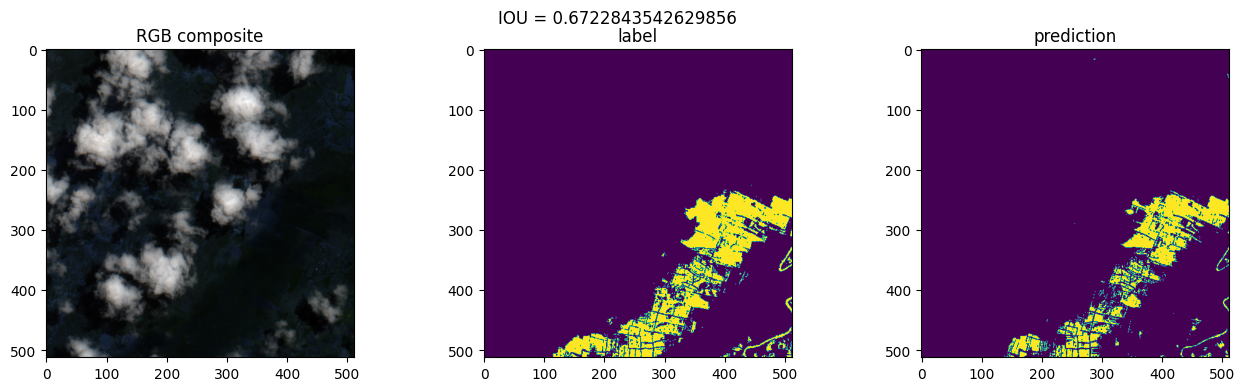

In [9]:
def calc_ndwi(img):
    """function to calcutlate ndwi with bands B03 and B08"""
    return ((img[2,:,:]-img[7,:,:]) / (img[2,:,:]+img[7,:,:]+np.e**-100))

def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

def normalize_img(img):
    """Normlize img of 3 bands so they can ploted as a composite"""
    red_n = normalize(img[:,:,0])
    green_n = normalize(img[:,:,1])
    blue_n = normalize(img[:,:,2])
    rgb_composite_n= np.dstack((red_n, green_n, blue_n))
    return (rgb_composite_n)

def plot_results(images,labels,thresh):
    """
    function get images and labels paths, draw a random image
    and plot the RGB, laebl mask and predicted label
    """
    random_image = np.random.randint(len(images))
    # plot rgb image, true label, predicted label
    fig, axs = plt.subplots(1,3,figsize=(16,4))
    img = skimage.io.imread(images[random_image])
    img_ndwi = calc_ndwi(img)
    img = np.moveaxis(img[1:4,:,:],0,-1)

    masked_img = (img_ndwi>thresh)
    label_img = skimage.io.imread(labels[random_image])
    masked_label = label_img>0 #because the label has -1=no_data,0=not_water,1=water

    intersection = np.sum(masked_img * masked_label)+np.e**-10
    union = np.sum(masked_img)+np.sum(masked_label) - intersection + np.e**-100

    IOU = intersection / union

    plt.suptitle(f'IOU = {IOU}')
    axs[0].imshow(normalize_img(img))
    axs[0].title.set_text('RGB composite')
    axs[1].imshow(label_img>0)
    axs[1].title.set_text('label')
    axs[2].imshow(masked_img)
    axs[2].title.set_text('prediction')
    return label_img,img_ndwi

#use one of my selected thresholds from the .py file
thresh1 = -0.161
thresh2 = 0.115
thresh0 = 0
label,img = plot_results(test_imgs,test_labels,thresh0)